# Stacking random forest algorithms

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import utils as u

import matplotlib.pylab as plt
plt.style.use('ggplot')

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

%run utils.py

In [2]:
metaData = u.getAllMetadata()

train = u.getAllTrainData()

In [3]:
##### NEW POSITION
train_data_mod = train.copy()
train_data_mod["latitude"] = train_data_mod["latitude"] -  train_data_mod["latitude"].mean()
train_data_mod["longitude"] = train_data_mod["longitude"] -  train_data_mod["longitude"].mean()

# Convert to polar coordinates
train_data_mod["r"] =  np.sqrt(train_data_mod["latitude"]**2 + train_data_mod["longitude"]**2)
train_data_mod["theta"] = np.arctan(train_data_mod["longitude"]/train_data_mod["latitude"])
train = train_data_mod
train.columns

# train = train[np.abs(stats.zscore(train["price"]) < 7)]


# for price in range()
trendline = np.polyfit(train['r'], (train['price']), 10)
trend = np.poly1d(trendline)
# r_new = np.linspace(train['r'].min(), train['r'].max(), 23005)

price_new = trend(train['r'])

train["price_new"] = price_new


## First RF algorithm

In [4]:
####### SETTINGS ##############
test_size = 0.2
all_features = ['seller','area_total','area_kitchen','area_living','floor','rooms','layout','ceiling','bathrooms_shared','bathrooms_private','windows_court','windows_street','balconies','loggias','condition','phones','building_id', 'new','latitude','longitude','district','constructed','material','stories','elevator_without','elevator_passenger','elevator_service','parking','garbage_chute','heating']
random_state_split = 42

outliers_value = 4
features = ["area_total", "ceiling", "latitude", "longitude", "floor", "district"] 
n_estimators=500
criterion='mse'          #root_mean_squared_log_error
max_depth=None
min_weight_fraction_leaf=0.0
max_features='auto'
max_leaf_nodes=None
min_impurity_decrease=0.0
bootstrap=True
oob_score=False
n_jobs=-1
random_state_model=12
verbose=0
warm_start=False
ccp_alpha=0.0
max_samples=None



In [5]:
# area_living
train = u.fillnaReg(train, ['area_total'], 'area_living')

# area_kitchen
train = u.fillnaReg(train, ['area_total', 'area_living'], 'area_kitchen')

# ceiling
train = u.fillnaReg(train, ['stories'], 'ceiling')

train.fillna(train.mean(), inplace = True)


In [6]:
train_data, test_data = train_test_split(train, test_size=test_size, random_state=random_state_split, stratify=np.log(train.price).round())
X_train, y_train = train_data[features], train_data['price']
X_test, y_test = test_data[features], test_data['price']

In [7]:
model1 = RandomForestRegressor(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    min_impurity_decrease=min_impurity_decrease,
    bootstrap=bootstrap,
    oob_score=oob_score,
    n_jobs=n_jobs,
    random_state=random_state_model,
    verbose=verbose,
    warm_start=warm_start,
    ccp_alpha=ccp_alpha,
    max_samples=max_samples
)
model1.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=12)

Test MSE: 0.1683084984361153


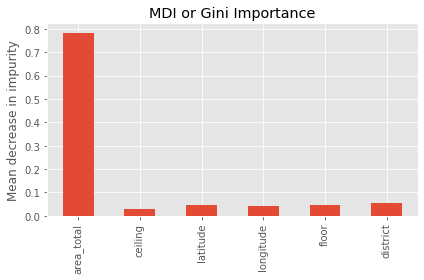

In [8]:
rf_prediction_1 = model1.predict(X_test)
rf_mse_1 = root_mean_squared_log_error(rf_prediction_1, y_test)
print('Test MSLE:', rf_mse_1)

u.getFeatureImportanceGraph(model1, X_train)

Text(0, 0.5, 'Ground Truth')

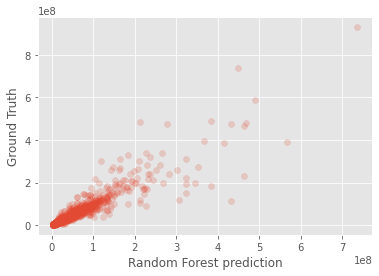

In [9]:
plt.scatter(rf_prediction_1, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

## Second RF algorithm

In [10]:
####### SETTINGS ##############
outliers_value = 4
features = ["rooms", "district", "r", "theta", "stories", "bathrooms_shared", "constructed", "price_new"] 
n_estimators=500
criterion='mse'          #root_mean_squared_log_error
max_depth=None
min_weight_fraction_leaf=0.0
max_features='sqrt'
max_leaf_nodes=None
min_impurity_decrease=0.0
bootstrap=True
oob_score=False
n_jobs=-1
random_state_model=12
verbose=0
warm_start=True
ccp_alpha=0.0
max_samples=None

In [11]:
X_train = train_data[features]
X_test = test_data[features]

In [12]:
model2 = RandomForestRegressor(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
#     min_samples_split=2,
#     min_samples_leaf=2,
    min_weight_fraction_leaf=min_weight_fraction_leaf,
    max_features=max_features,
    max_leaf_nodes=max_leaf_nodes,
    min_impurity_decrease=min_impurity_decrease,
    bootstrap=bootstrap,
    oob_score=oob_score,
    n_jobs=n_jobs,
    random_state=random_state_model,
    verbose=verbose,
    warm_start=warm_start,
    ccp_alpha=ccp_alpha,
    max_samples=max_samples
)
model2.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500, n_jobs=-1,
                      random_state=12, warm_start=True)

Test MSE: 0.2391129462315839


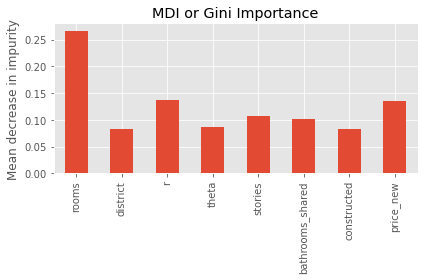

In [13]:
rf_prediction_2 = model2.predict(X_test)
rf_mse_2 = root_mean_squared_log_error(rf_prediction_2, y_test)
print('Test MSLE:', rf_mse_2)

u.getFeatureImportanceGraph(model2, X_train)



Text(0, 0.5, 'Ground Truth')

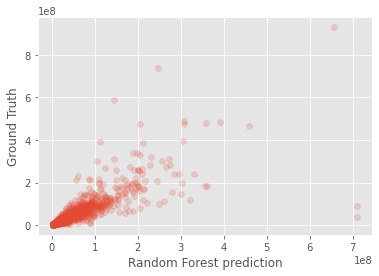

In [14]:
plt.scatter(rf_prediction_2, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

## Stacking results

Test MSE: 0.1645205269034919


Text(0, 0.5, 'Ground Truth')

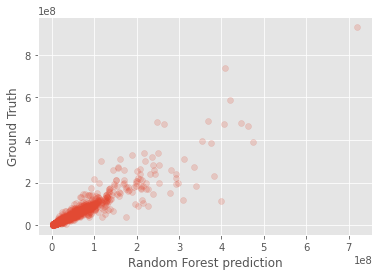

In [15]:
rf_predictions = np.array([rf_prediction_1, rf_prediction_2])
rf_prediction = np.average(rf_predictions, axis=0, weights=[0.8, 0.2])

rf_mse = root_mean_squared_log_error(rf_prediction, y_test)
print('Test MSE:', rf_mse)

plt.scatter(rf_prediction, y_test, alpha=0.2)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

In [25]:
# import json
# ########## Create submission
# # Fit model to the full dataset 

# test = u.getAllTestData()

# # ##### NEW POSITION
# test_data_mod = test.copy()
# test_data_mod["latitude"] = test_data_mod["latitude"] -  test_data_mod["latitude"].mean()
# test_data_mod["longitude"] = test_data_mod["longitude"] -  test_data_mod["longitude"].mean()

# # Convert to polar coordinates
# test_data_mod["r"] =  np.sqrt(test_data_mod["latitude"]**2 + test_data_mod["longitude"]**2)
# test_data_mod["theta"] = np.arctan(test_data_mod["longitude"]/test_data_mod["latitude"])
# test = test_data_mod
# test.columns


# ###### MISSING VALUES
# # area_living
# test = u.fillnaReg(test, ['area_total'], 'area_living')
# # area_kitchen
# test = u.fillnaReg(test, ['area_total', 'area_living'], 'area_kitchen')
# # ceiling
# test = u.fillnaReg(test, ['stories'], 'ceiling')
# # # district
# # test = utils.fillnaReg(test, ['r', 'theta'], 'district')

# price_new = trend(test['r'])

# test['price_new'] = price_new

# train = train.fillna(train.mean())
# test = test.fillna(test.mean())


# ####### MODEL 1
# features_1 = ["area_total", "ceiling", "latitude", "longitude", "floor", "district"] 
# X_train_1 = train[features_1]
# y_train = train['price']
# model1 = RandomForestRegressor(
#     n_estimators=n_estimators,
#     criterion=criterion,
#     max_depth=max_depth,
#     min_weight_fraction_leaf=min_weight_fraction_leaf,
#     max_features=max_features,
#     max_leaf_nodes=max_leaf_nodes,
#     min_impurity_decrease=min_impurity_decrease,
#     bootstrap=bootstrap,
#     oob_score=oob_score,
#     n_jobs=n_jobs,
#     random_state=random_state_model,
#     verbose=verbose,
#     warm_start=warm_start,
#     ccp_alpha=ccp_alpha,
#     max_samples=max_samples
# )
# model1.fit(X_train_1, y_train)

# # Generate predictions for test set 
# X_test_1 = test[features_1]
# X_test_nan_1 = X_test_1.isna().any(axis=1)
# y_test_hat_1 = model1.predict(X_test_1[~X_test_nan_1])

# ############ MODEL 2
# features_2 = ["rooms", "district", "r", "theta", "stories", "bathrooms_shared", "constructed", "price_new"] 
# X_train_2 = train[features_2]
# model2 = RandomForestRegressor(
#     n_estimators=n_estimators,
#     criterion=criterion,
#     max_depth=max_depth,
#     min_weight_fraction_leaf=min_weight_fraction_leaf,
#     max_features=max_features,
#     max_leaf_nodes=max_leaf_nodes,
#     min_impurity_decrease=min_impurity_decrease,
#     bootstrap=bootstrap,
#     oob_score=oob_score,
#     n_jobs=n_jobs,
#     random_state=random_state_model,
#     verbose=verbose,
#     warm_start=warm_start,
#     ccp_alpha=ccp_alpha,
#     max_samples=max_samples
# )
# model2.fit(X_train_2, y_train)

# # Generate predictions for test set 
# X_test_2 = test[features_2]
# X_test_nan_2 = X_test_2.isna().any(axis=1)
# y_test_hat_2 = model2.predict(X_test_2[~X_test_nan_2])


# ###### stacking
# rf_predictions = np.array([y_test_hat_1, y_test_hat_2])
# y_test_hat = np.average(rf_predictions, axis=0, weights=[0.8, 0.2])


# # Construct submission dataframe
# submission = pd.DataFrame()
# submission['id'] = test.id
# submission['price_prediction'] = y_test_hat # Predict on non-nan entries
# submission['price_prediction'].fillna(y_train.mean(), inplace=True) # Fill missing entries with mean predictor
# print(f'Generated {len(submission)} predictions')

# # Export submission to csv with headers

# ############################################ CHANGE NAME !!!!!!!!!!
# submission.to_csv('sample_RF_13.csv', index=False)
# settings = {
#     'train_MSE': root_mean_squared_log_error(rf_prediction, y_test),
#     'features':{0:features_1, 1:features_2}, 
#     'outliers_value':outliers_value,
#     'nan_delete':'mean',
#     'test_size' : test_size,
#     'random_state_split' :  random_state_split,
#     'n_estimators': n_estimators,
#     'criterion': criterion,
#     'max_depth': max_depth,
#     'min_weight_fraction_leaf': min_weight_fraction_leaf,
#     'max_features': max_features,
#     'max_leaf_nodes': max_leaf_nodes,
#     'min_impurity_decrease': min_impurity_decrease,
#     'bootstrap': bootstrap,
#     'oob_score': oob_score,
#     'n_jobs': n_jobs,
#     'random_state': random_state_model,
#     'verbose': verbose,
#     'warm_start': warm_start,
#     'ccp_alpha': ccp_alpha,
#     'max_samples': max_samples,
#     'other':{0:'First try of stacking two RF with different features',
#         'Missing values' : {
#             "Missing area_living": "reg on area_total", 
#             "Missing area_kitchen": "reg on area_total and area_living", 
#             "Missing ceiling": "reg on stories"
#         }    
#     }
# }

# with open('sample_RF_13_settings.json', 'w') as fp:
#     json.dump(settings, fp)